# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.48KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

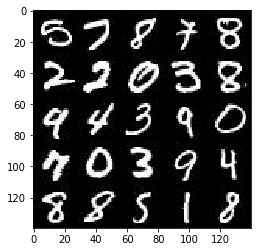

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

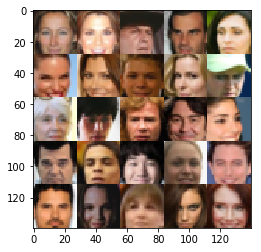

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.7037... Generator Loss: 0.3348
Epoch 1/2... Batch 20... Discriminator Loss: 1.0931... Generator Loss: 0.7444
Epoch 1/2... Batch 30... Discriminator Loss: 0.9218... Generator Loss: 6.0485
Epoch 1/2... Batch 40... Discriminator Loss: 0.9039... Generator Loss: 1.1450
Epoch 1/2... Batch 50... Discriminator Loss: 1.1701... Generator Loss: 6.5904
Epoch 1/2... Batch 60... Discriminator Loss: 0.5477... Generator Loss: 2.7458
Epoch 1/2... Batch 70... Discriminator Loss: 0.8409... Generator Loss: 1.4823
Epoch 1/2... Batch 80... Discriminator Loss: 1.1861... Generator Loss: 2.5056
Epoch 1/2... Batch 90... Discriminator Loss: 1.7420... Generator Loss: 3.5064
Epoch 1/2... Batch 100... Discriminator Loss: 1.1349... Generator Loss: 1.3052


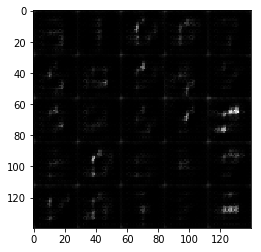

Epoch 1/2... Batch 110... Discriminator Loss: 1.7245... Generator Loss: 3.3591
Epoch 1/2... Batch 120... Discriminator Loss: 1.1875... Generator Loss: 0.8210
Epoch 1/2... Batch 130... Discriminator Loss: 1.1656... Generator Loss: 0.9299
Epoch 1/2... Batch 140... Discriminator Loss: 1.7111... Generator Loss: 0.4239
Epoch 1/2... Batch 150... Discriminator Loss: 1.3278... Generator Loss: 0.7514
Epoch 1/2... Batch 160... Discriminator Loss: 1.4666... Generator Loss: 2.2504
Epoch 1/2... Batch 170... Discriminator Loss: 1.3587... Generator Loss: 0.6153
Epoch 1/2... Batch 180... Discriminator Loss: 1.2059... Generator Loss: 1.2432
Epoch 1/2... Batch 190... Discriminator Loss: 1.2501... Generator Loss: 0.8088
Epoch 1/2... Batch 200... Discriminator Loss: 1.1691... Generator Loss: 1.0540


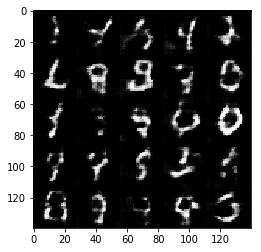

Epoch 1/2... Batch 210... Discriminator Loss: 1.4897... Generator Loss: 0.4627
Epoch 1/2... Batch 220... Discriminator Loss: 1.2165... Generator Loss: 0.8291
Epoch 1/2... Batch 230... Discriminator Loss: 1.1814... Generator Loss: 0.7836
Epoch 1/2... Batch 240... Discriminator Loss: 1.3338... Generator Loss: 0.5947
Epoch 1/2... Batch 250... Discriminator Loss: 1.2266... Generator Loss: 0.9161
Epoch 1/2... Batch 260... Discriminator Loss: 1.2539... Generator Loss: 1.6116
Epoch 1/2... Batch 270... Discriminator Loss: 1.2333... Generator Loss: 0.6712
Epoch 1/2... Batch 280... Discriminator Loss: 1.6596... Generator Loss: 0.3733
Epoch 1/2... Batch 290... Discriminator Loss: 1.1251... Generator Loss: 0.9194
Epoch 1/2... Batch 300... Discriminator Loss: 1.1341... Generator Loss: 1.2121


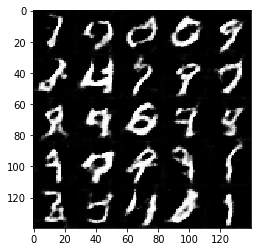

Epoch 1/2... Batch 310... Discriminator Loss: 1.1487... Generator Loss: 0.8626
Epoch 1/2... Batch 320... Discriminator Loss: 1.4334... Generator Loss: 0.5018
Epoch 1/2... Batch 330... Discriminator Loss: 1.1068... Generator Loss: 1.0701
Epoch 1/2... Batch 340... Discriminator Loss: 1.1419... Generator Loss: 0.8804
Epoch 1/2... Batch 350... Discriminator Loss: 1.4882... Generator Loss: 2.0346
Epoch 1/2... Batch 360... Discriminator Loss: 1.2368... Generator Loss: 0.7768
Epoch 1/2... Batch 370... Discriminator Loss: 1.0950... Generator Loss: 1.1894
Epoch 1/2... Batch 380... Discriminator Loss: 1.2730... Generator Loss: 0.6816
Epoch 1/2... Batch 390... Discriminator Loss: 1.2608... Generator Loss: 1.6260
Epoch 1/2... Batch 400... Discriminator Loss: 1.1884... Generator Loss: 0.7964


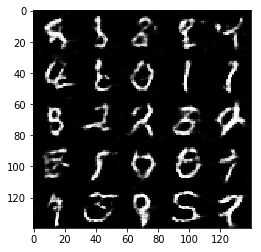

Epoch 1/2... Batch 410... Discriminator Loss: 1.8594... Generator Loss: 0.2920
Epoch 1/2... Batch 420... Discriminator Loss: 1.1510... Generator Loss: 0.8405
Epoch 1/2... Batch 430... Discriminator Loss: 1.1464... Generator Loss: 0.9024
Epoch 1/2... Batch 440... Discriminator Loss: 1.1424... Generator Loss: 0.8640
Epoch 1/2... Batch 450... Discriminator Loss: 1.3319... Generator Loss: 0.6220
Epoch 1/2... Batch 460... Discriminator Loss: 1.2495... Generator Loss: 1.3219
Epoch 2/2... Batch 10... Discriminator Loss: 1.1993... Generator Loss: 1.3860
Epoch 2/2... Batch 20... Discriminator Loss: 1.2462... Generator Loss: 1.3722
Epoch 2/2... Batch 30... Discriminator Loss: 1.3104... Generator Loss: 0.6618
Epoch 2/2... Batch 40... Discriminator Loss: 1.0954... Generator Loss: 1.0087
Epoch 2/2... Batch 50... Discriminator Loss: 1.1506... Generator Loss: 0.9199
Epoch 2/2... Batch 60... Discriminator Loss: 1.1990... Generator Loss: 1.0326
Epoch 2/2... Batch 70... Discriminator Loss: 1.1864... Gen

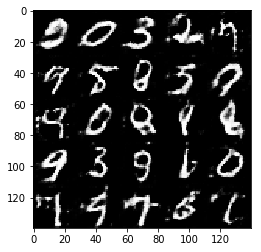

Epoch 2/2... Batch 110... Discriminator Loss: 1.1896... Generator Loss: 0.7751
Epoch 2/2... Batch 120... Discriminator Loss: 1.3435... Generator Loss: 0.5962
Epoch 2/2... Batch 130... Discriminator Loss: 1.1660... Generator Loss: 0.9605
Epoch 2/2... Batch 140... Discriminator Loss: 1.2870... Generator Loss: 0.6315
Epoch 2/2... Batch 150... Discriminator Loss: 1.1635... Generator Loss: 0.7856
Epoch 2/2... Batch 160... Discriminator Loss: 1.1300... Generator Loss: 0.8783
Epoch 2/2... Batch 170... Discriminator Loss: 1.4271... Generator Loss: 0.5231
Epoch 2/2... Batch 180... Discriminator Loss: 1.1431... Generator Loss: 1.3488
Epoch 2/2... Batch 190... Discriminator Loss: 1.2969... Generator Loss: 0.6499
Epoch 2/2... Batch 200... Discriminator Loss: 1.1460... Generator Loss: 0.9866


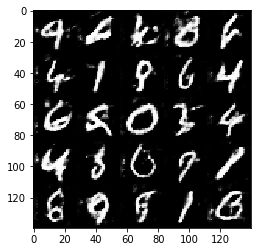

Epoch 2/2... Batch 210... Discriminator Loss: 1.1119... Generator Loss: 1.0636
Epoch 2/2... Batch 220... Discriminator Loss: 1.2649... Generator Loss: 0.8252
Epoch 2/2... Batch 230... Discriminator Loss: 1.4327... Generator Loss: 0.4770
Epoch 2/2... Batch 240... Discriminator Loss: 1.2263... Generator Loss: 0.8280
Epoch 2/2... Batch 250... Discriminator Loss: 1.2757... Generator Loss: 0.6325
Epoch 2/2... Batch 260... Discriminator Loss: 1.2605... Generator Loss: 0.7552
Epoch 2/2... Batch 270... Discriminator Loss: 1.2992... Generator Loss: 0.5943
Epoch 2/2... Batch 280... Discriminator Loss: 1.9228... Generator Loss: 0.2805
Epoch 2/2... Batch 290... Discriminator Loss: 1.2289... Generator Loss: 0.7123
Epoch 2/2... Batch 300... Discriminator Loss: 1.1322... Generator Loss: 1.0964


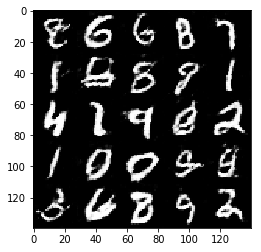

Epoch 2/2... Batch 310... Discriminator Loss: 1.1892... Generator Loss: 0.8776
Epoch 2/2... Batch 320... Discriminator Loss: 1.1431... Generator Loss: 0.9954
Epoch 2/2... Batch 330... Discriminator Loss: 1.4329... Generator Loss: 0.4855
Epoch 2/2... Batch 340... Discriminator Loss: 1.4002... Generator Loss: 0.5011
Epoch 2/2... Batch 350... Discriminator Loss: 1.1722... Generator Loss: 0.8445
Epoch 2/2... Batch 360... Discriminator Loss: 1.2740... Generator Loss: 0.6983
Epoch 2/2... Batch 370... Discriminator Loss: 1.3942... Generator Loss: 2.0029
Epoch 2/2... Batch 380... Discriminator Loss: 1.4681... Generator Loss: 0.4645
Epoch 2/2... Batch 390... Discriminator Loss: 1.3288... Generator Loss: 0.5661
Epoch 2/2... Batch 400... Discriminator Loss: 1.1980... Generator Loss: 0.8659


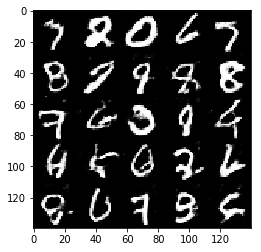

Epoch 2/2... Batch 410... Discriminator Loss: 1.2976... Generator Loss: 0.9300
Epoch 2/2... Batch 420... Discriminator Loss: 1.0924... Generator Loss: 0.9138
Epoch 2/2... Batch 430... Discriminator Loss: 1.1597... Generator Loss: 0.8819
Epoch 2/2... Batch 440... Discriminator Loss: 1.1954... Generator Loss: 0.7809
Epoch 2/2... Batch 450... Discriminator Loss: 1.2497... Generator Loss: 0.6582
Epoch 2/2... Batch 460... Discriminator Loss: 1.3320... Generator Loss: 0.5487


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.5756... Generator Loss: 0.4767
Epoch 1/1... Batch 20... Discriminator Loss: 0.9792... Generator Loss: 1.0228
Epoch 1/1... Batch 30... Discriminator Loss: 0.7130... Generator Loss: 1.4921
Epoch 1/1... Batch 40... Discriminator Loss: 0.5562... Generator Loss: 2.0407
Epoch 1/1... Batch 50... Discriminator Loss: 0.5790... Generator Loss: 2.0413
Epoch 1/1... Batch 60... Discriminator Loss: 0.6700... Generator Loss: 1.6099
Epoch 1/1... Batch 70... Discriminator Loss: 0.5190... Generator Loss: 2.9821
Epoch 1/1... Batch 80... Discriminator Loss: 0.4441... Generator Loss: 2.8597
Epoch 1/1... Batch 90... Discriminator Loss: 0.8289... Generator Loss: 1.0578
Epoch 1/1... Batch 100... Discriminator Loss: 0.5189... Generator Loss: 3.5895


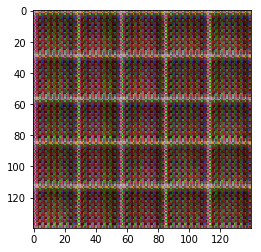

Epoch 1/1... Batch 110... Discriminator Loss: 1.1675... Generator Loss: 0.6901
Epoch 1/1... Batch 120... Discriminator Loss: 0.8458... Generator Loss: 1.8115
Epoch 1/1... Batch 130... Discriminator Loss: 0.8712... Generator Loss: 1.2470
Epoch 1/1... Batch 140... Discriminator Loss: 0.6811... Generator Loss: 1.7641
Epoch 1/1... Batch 150... Discriminator Loss: 0.8048... Generator Loss: 2.2010
Epoch 1/1... Batch 160... Discriminator Loss: 0.7877... Generator Loss: 1.2810
Epoch 1/1... Batch 170... Discriminator Loss: 0.7578... Generator Loss: 1.4227
Epoch 1/1... Batch 180... Discriminator Loss: 0.7113... Generator Loss: 2.1109
Epoch 1/1... Batch 190... Discriminator Loss: 0.7854... Generator Loss: 1.8383
Epoch 1/1... Batch 200... Discriminator Loss: 0.6436... Generator Loss: 2.1185


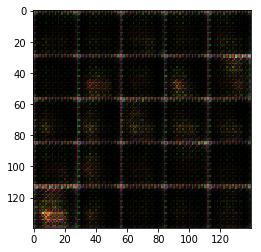

Epoch 1/1... Batch 210... Discriminator Loss: 0.7490... Generator Loss: 3.3514
Epoch 1/1... Batch 220... Discriminator Loss: 1.0462... Generator Loss: 0.8537
Epoch 1/1... Batch 230... Discriminator Loss: 0.6949... Generator Loss: 2.1127
Epoch 1/1... Batch 240... Discriminator Loss: 0.7120... Generator Loss: 1.7072
Epoch 1/1... Batch 250... Discriminator Loss: 1.1205... Generator Loss: 0.9011
Epoch 1/1... Batch 260... Discriminator Loss: 0.8320... Generator Loss: 2.2842
Epoch 1/1... Batch 270... Discriminator Loss: 0.8206... Generator Loss: 1.6511
Epoch 1/1... Batch 280... Discriminator Loss: 0.8562... Generator Loss: 1.2725
Epoch 1/1... Batch 290... Discriminator Loss: 1.0370... Generator Loss: 0.9508
Epoch 1/1... Batch 300... Discriminator Loss: 0.9186... Generator Loss: 1.6474


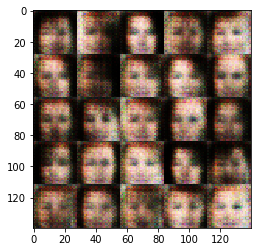

Epoch 1/1... Batch 310... Discriminator Loss: 1.1830... Generator Loss: 0.6933
Epoch 1/1... Batch 320... Discriminator Loss: 0.7617... Generator Loss: 1.7756
Epoch 1/1... Batch 330... Discriminator Loss: 1.1883... Generator Loss: 3.5674
Epoch 1/1... Batch 340... Discriminator Loss: 0.8614... Generator Loss: 1.3399
Epoch 1/1... Batch 350... Discriminator Loss: 0.9500... Generator Loss: 1.1335
Epoch 1/1... Batch 360... Discriminator Loss: 1.1101... Generator Loss: 0.9641
Epoch 1/1... Batch 370... Discriminator Loss: 1.6942... Generator Loss: 3.7119
Epoch 1/1... Batch 380... Discriminator Loss: 1.1377... Generator Loss: 0.8314
Epoch 1/1... Batch 390... Discriminator Loss: 0.7495... Generator Loss: 1.7350
Epoch 1/1... Batch 400... Discriminator Loss: 0.8256... Generator Loss: 1.5859


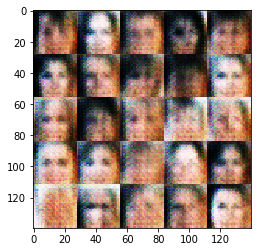

Epoch 1/1... Batch 410... Discriminator Loss: 0.8285... Generator Loss: 2.4910
Epoch 1/1... Batch 420... Discriminator Loss: 0.9870... Generator Loss: 1.3608
Epoch 1/1... Batch 430... Discriminator Loss: 0.8863... Generator Loss: 1.2001
Epoch 1/1... Batch 440... Discriminator Loss: 0.7766... Generator Loss: 1.3678
Epoch 1/1... Batch 450... Discriminator Loss: 0.7862... Generator Loss: 1.2605
Epoch 1/1... Batch 460... Discriminator Loss: 0.8343... Generator Loss: 1.2191
Epoch 1/1... Batch 470... Discriminator Loss: 0.9066... Generator Loss: 1.3528
Epoch 1/1... Batch 480... Discriminator Loss: 0.9235... Generator Loss: 2.3044
Epoch 1/1... Batch 490... Discriminator Loss: 1.1083... Generator Loss: 0.9433
Epoch 1/1... Batch 500... Discriminator Loss: 1.0267... Generator Loss: 1.7898


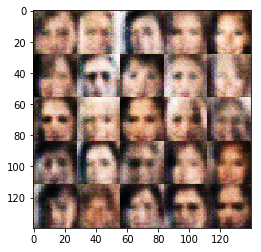

Epoch 1/1... Batch 510... Discriminator Loss: 0.7447... Generator Loss: 1.8048
Epoch 1/1... Batch 520... Discriminator Loss: 0.7783... Generator Loss: 1.5461
Epoch 1/1... Batch 530... Discriminator Loss: 0.8612... Generator Loss: 1.1158
Epoch 1/1... Batch 540... Discriminator Loss: 1.1258... Generator Loss: 0.8369
Epoch 1/1... Batch 550... Discriminator Loss: 1.1635... Generator Loss: 0.7748
Epoch 1/1... Batch 560... Discriminator Loss: 1.1594... Generator Loss: 0.8216
Epoch 1/1... Batch 570... Discriminator Loss: 0.8524... Generator Loss: 1.4109
Epoch 1/1... Batch 580... Discriminator Loss: 0.8684... Generator Loss: 1.8691
Epoch 1/1... Batch 590... Discriminator Loss: 1.1333... Generator Loss: 0.7799
Epoch 1/1... Batch 600... Discriminator Loss: 1.0847... Generator Loss: 1.4250


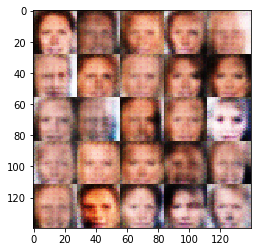

Epoch 1/1... Batch 610... Discriminator Loss: 1.0444... Generator Loss: 1.2191
Epoch 1/1... Batch 620... Discriminator Loss: 1.1208... Generator Loss: 1.6976
Epoch 1/1... Batch 630... Discriminator Loss: 0.9423... Generator Loss: 1.1718
Epoch 1/1... Batch 640... Discriminator Loss: 1.5757... Generator Loss: 0.4439
Epoch 1/1... Batch 650... Discriminator Loss: 1.2453... Generator Loss: 0.7489
Epoch 1/1... Batch 660... Discriminator Loss: 0.8031... Generator Loss: 1.5934
Epoch 1/1... Batch 670... Discriminator Loss: 1.0352... Generator Loss: 1.0839
Epoch 1/1... Batch 680... Discriminator Loss: 1.1444... Generator Loss: 0.7429
Epoch 1/1... Batch 690... Discriminator Loss: 1.1403... Generator Loss: 1.1799
Epoch 1/1... Batch 700... Discriminator Loss: 1.1908... Generator Loss: 1.2696


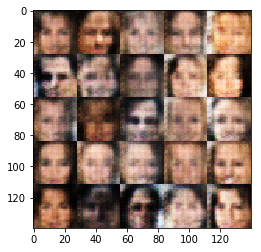

Epoch 1/1... Batch 710... Discriminator Loss: 0.9613... Generator Loss: 1.1449
Epoch 1/1... Batch 720... Discriminator Loss: 1.1609... Generator Loss: 1.6396
Epoch 1/1... Batch 730... Discriminator Loss: 1.1388... Generator Loss: 1.2940
Epoch 1/1... Batch 740... Discriminator Loss: 1.0558... Generator Loss: 1.2140
Epoch 1/1... Batch 750... Discriminator Loss: 1.0789... Generator Loss: 1.0882
Epoch 1/1... Batch 760... Discriminator Loss: 0.9112... Generator Loss: 1.3367
Epoch 1/1... Batch 770... Discriminator Loss: 0.9048... Generator Loss: 1.3758
Epoch 1/1... Batch 780... Discriminator Loss: 0.9479... Generator Loss: 1.2681
Epoch 1/1... Batch 790... Discriminator Loss: 1.0816... Generator Loss: 0.8971
Epoch 1/1... Batch 800... Discriminator Loss: 0.9540... Generator Loss: 1.1598


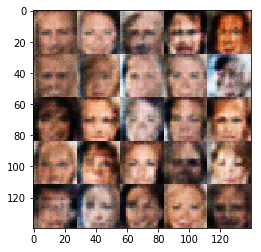

Epoch 1/1... Batch 810... Discriminator Loss: 1.0069... Generator Loss: 1.2287
Epoch 1/1... Batch 820... Discriminator Loss: 1.0281... Generator Loss: 1.2461
Epoch 1/1... Batch 830... Discriminator Loss: 1.0377... Generator Loss: 1.0061
Epoch 1/1... Batch 840... Discriminator Loss: 1.1037... Generator Loss: 1.1171
Epoch 1/1... Batch 850... Discriminator Loss: 1.0209... Generator Loss: 1.3604
Epoch 1/1... Batch 860... Discriminator Loss: 0.9981... Generator Loss: 1.1702
Epoch 1/1... Batch 870... Discriminator Loss: 1.0267... Generator Loss: 0.9620
Epoch 1/1... Batch 880... Discriminator Loss: 0.8684... Generator Loss: 1.4932
Epoch 1/1... Batch 890... Discriminator Loss: 1.1010... Generator Loss: 0.8015
Epoch 1/1... Batch 900... Discriminator Loss: 1.0317... Generator Loss: 1.0359


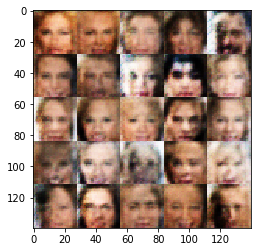

Epoch 1/1... Batch 910... Discriminator Loss: 1.1024... Generator Loss: 0.9359
Epoch 1/1... Batch 920... Discriminator Loss: 0.9745... Generator Loss: 1.5726
Epoch 1/1... Batch 930... Discriminator Loss: 1.0780... Generator Loss: 0.8687
Epoch 1/1... Batch 940... Discriminator Loss: 0.9829... Generator Loss: 1.3046
Epoch 1/1... Batch 950... Discriminator Loss: 0.9467... Generator Loss: 1.2500
Epoch 1/1... Batch 960... Discriminator Loss: 1.0812... Generator Loss: 0.8133
Epoch 1/1... Batch 970... Discriminator Loss: 1.0038... Generator Loss: 1.1154
Epoch 1/1... Batch 980... Discriminator Loss: 1.1435... Generator Loss: 1.5661
Epoch 1/1... Batch 990... Discriminator Loss: 1.0942... Generator Loss: 0.8938
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1349... Generator Loss: 0.7871


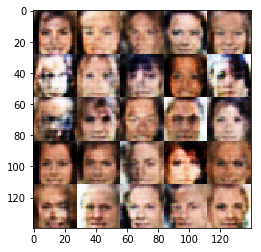

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9054... Generator Loss: 1.4703
Epoch 1/1... Batch 1020... Discriminator Loss: 1.0689... Generator Loss: 1.0342
Epoch 1/1... Batch 1030... Discriminator Loss: 1.1081... Generator Loss: 1.4727
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2041... Generator Loss: 0.7837
Epoch 1/1... Batch 1050... Discriminator Loss: 0.7506... Generator Loss: 1.4875
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1527... Generator Loss: 0.7648
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2451... Generator Loss: 1.1586
Epoch 1/1... Batch 1080... Discriminator Loss: 1.0632... Generator Loss: 0.9178
Epoch 1/1... Batch 1090... Discriminator Loss: 1.0747... Generator Loss: 0.7983
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1185... Generator Loss: 0.7655


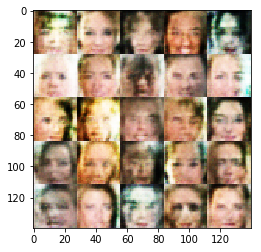

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1785... Generator Loss: 0.9405
Epoch 1/1... Batch 1120... Discriminator Loss: 0.9369... Generator Loss: 1.1066
Epoch 1/1... Batch 1130... Discriminator Loss: 1.1324... Generator Loss: 1.4715
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2957... Generator Loss: 0.6833
Epoch 1/1... Batch 1150... Discriminator Loss: 1.0824... Generator Loss: 1.2175
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0358... Generator Loss: 1.6028
Epoch 1/1... Batch 1170... Discriminator Loss: 1.0888... Generator Loss: 1.9673
Epoch 1/1... Batch 1180... Discriminator Loss: 0.9936... Generator Loss: 1.0100
Epoch 1/1... Batch 1190... Discriminator Loss: 0.9262... Generator Loss: 1.1992
Epoch 1/1... Batch 1200... Discriminator Loss: 0.9117... Generator Loss: 1.0382


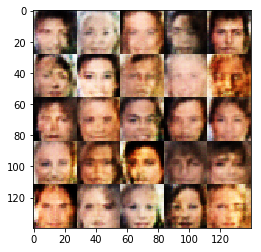

Epoch 1/1... Batch 1210... Discriminator Loss: 1.3630... Generator Loss: 0.8287
Epoch 1/1... Batch 1220... Discriminator Loss: 1.2899... Generator Loss: 0.7013
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7313... Generator Loss: 1.4930
Epoch 1/1... Batch 1240... Discriminator Loss: 0.9707... Generator Loss: 2.1057
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1117... Generator Loss: 1.4949
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1630... Generator Loss: 0.8610
Epoch 1/1... Batch 1270... Discriminator Loss: 1.1925... Generator Loss: 0.7088
Epoch 1/1... Batch 1280... Discriminator Loss: 1.0508... Generator Loss: 1.2030
Epoch 1/1... Batch 1290... Discriminator Loss: 0.9629... Generator Loss: 1.3773
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2254... Generator Loss: 0.6657


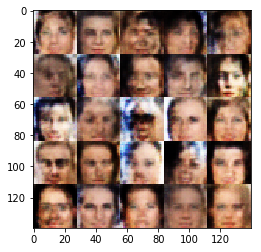

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1892... Generator Loss: 0.7915
Epoch 1/1... Batch 1320... Discriminator Loss: 0.9669... Generator Loss: 1.1375
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1451... Generator Loss: 0.8787
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0551... Generator Loss: 1.1246
Epoch 1/1... Batch 1350... Discriminator Loss: 0.9987... Generator Loss: 1.1049
Epoch 1/1... Batch 1360... Discriminator Loss: 1.1318... Generator Loss: 1.0990
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0330... Generator Loss: 1.1431
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9936... Generator Loss: 2.6077
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1766... Generator Loss: 0.9088
Epoch 1/1... Batch 1400... Discriminator Loss: 1.0250... Generator Loss: 1.0915


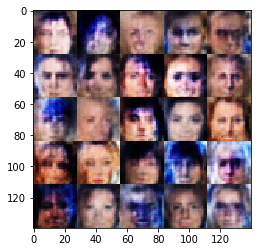

Epoch 1/1... Batch 1410... Discriminator Loss: 1.0521... Generator Loss: 1.1751
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0982... Generator Loss: 1.0443
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1853... Generator Loss: 1.0082
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1399... Generator Loss: 1.1065
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2882... Generator Loss: 1.0313
Epoch 1/1... Batch 1460... Discriminator Loss: 0.9785... Generator Loss: 1.0691
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0988... Generator Loss: 0.9709
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0824... Generator Loss: 1.3956
Epoch 1/1... Batch 1490... Discriminator Loss: 1.1099... Generator Loss: 0.8579
Epoch 1/1... Batch 1500... Discriminator Loss: 0.8379... Generator Loss: 1.2757


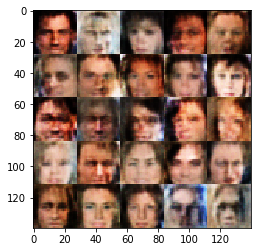

Epoch 1/1... Batch 1510... Discriminator Loss: 1.0250... Generator Loss: 1.0363
Epoch 1/1... Batch 1520... Discriminator Loss: 1.0560... Generator Loss: 1.0621
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0056... Generator Loss: 1.1365
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0896... Generator Loss: 0.8127
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1339... Generator Loss: 0.9288
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1195... Generator Loss: 1.1214
Epoch 1/1... Batch 1570... Discriminator Loss: 1.1267... Generator Loss: 1.0818
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4070... Generator Loss: 0.5771
Epoch 1/1... Batch 1590... Discriminator Loss: 1.4102... Generator Loss: 0.5006
Epoch 1/1... Batch 1600... Discriminator Loss: 1.2056... Generator Loss: 0.7794


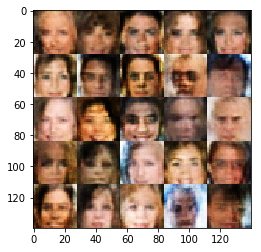

Epoch 1/1... Batch 1610... Discriminator Loss: 0.9813... Generator Loss: 1.0900
Epoch 1/1... Batch 1620... Discriminator Loss: 1.2846... Generator Loss: 0.8983
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0328... Generator Loss: 1.2386
Epoch 1/1... Batch 1640... Discriminator Loss: 1.1037... Generator Loss: 0.8531
Epoch 1/1... Batch 1650... Discriminator Loss: 0.9749... Generator Loss: 1.4529
Epoch 1/1... Batch 1660... Discriminator Loss: 1.0276... Generator Loss: 1.0179
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2355... Generator Loss: 0.8693
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0866... Generator Loss: 1.1130
Epoch 1/1... Batch 1690... Discriminator Loss: 0.7662... Generator Loss: 1.4841
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2598... Generator Loss: 1.1159


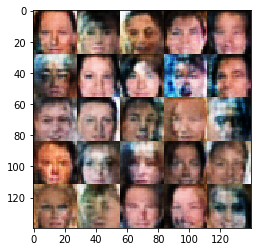

Epoch 1/1... Batch 1710... Discriminator Loss: 1.2068... Generator Loss: 0.7873
Epoch 1/1... Batch 1720... Discriminator Loss: 0.9921... Generator Loss: 1.0287
Epoch 1/1... Batch 1730... Discriminator Loss: 0.9194... Generator Loss: 1.2651
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3326... Generator Loss: 0.7065
Epoch 1/1... Batch 1750... Discriminator Loss: 0.9458... Generator Loss: 1.2428
Epoch 1/1... Batch 1760... Discriminator Loss: 0.8649... Generator Loss: 1.3668
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3617... Generator Loss: 0.5420
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0483... Generator Loss: 0.9040
Epoch 1/1... Batch 1790... Discriminator Loss: 1.0613... Generator Loss: 0.8450
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0951... Generator Loss: 0.9544


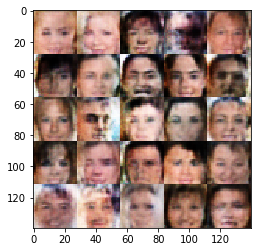

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9115... Generator Loss: 1.2931
Epoch 1/1... Batch 1820... Discriminator Loss: 1.4167... Generator Loss: 0.6148
Epoch 1/1... Batch 1830... Discriminator Loss: 1.2009... Generator Loss: 0.8191
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1712... Generator Loss: 0.7369
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2198... Generator Loss: 0.8870
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2431... Generator Loss: 0.7523
Epoch 1/1... Batch 1870... Discriminator Loss: 1.0140... Generator Loss: 1.5249
Epoch 1/1... Batch 1880... Discriminator Loss: 0.9744... Generator Loss: 1.1687
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3069... Generator Loss: 1.8185
Epoch 1/1... Batch 1900... Discriminator Loss: 1.0962... Generator Loss: 0.8204


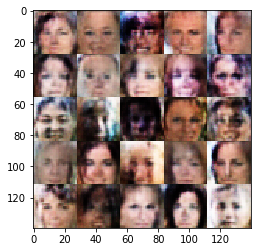

Epoch 1/1... Batch 1910... Discriminator Loss: 1.4335... Generator Loss: 0.5237
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0708... Generator Loss: 0.9324
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9866... Generator Loss: 1.0825
Epoch 1/1... Batch 1940... Discriminator Loss: 1.6598... Generator Loss: 0.3822
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1218... Generator Loss: 0.8793
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1330... Generator Loss: 0.8123
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1220... Generator Loss: 0.8554
Epoch 1/1... Batch 1980... Discriminator Loss: 0.9859... Generator Loss: 1.4677
Epoch 1/1... Batch 1990... Discriminator Loss: 1.1305... Generator Loss: 0.8057
Epoch 1/1... Batch 2000... Discriminator Loss: 1.1755... Generator Loss: 0.8140


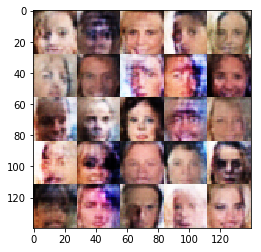

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0880... Generator Loss: 1.3497
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1548... Generator Loss: 0.9846
Epoch 1/1... Batch 2030... Discriminator Loss: 1.0618... Generator Loss: 1.0263
Epoch 1/1... Batch 2040... Discriminator Loss: 0.8665... Generator Loss: 1.1915
Epoch 1/1... Batch 2050... Discriminator Loss: 1.0244... Generator Loss: 0.9438
Epoch 1/1... Batch 2060... Discriminator Loss: 0.8995... Generator Loss: 1.2760
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1446... Generator Loss: 0.8292
Epoch 1/1... Batch 2080... Discriminator Loss: 0.9234... Generator Loss: 1.1727
Epoch 1/1... Batch 2090... Discriminator Loss: 1.1250... Generator Loss: 0.8269
Epoch 1/1... Batch 2100... Discriminator Loss: 0.8344... Generator Loss: 1.7192


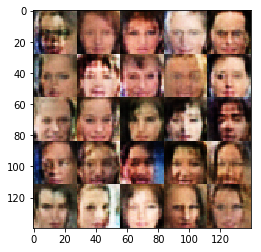

Epoch 1/1... Batch 2110... Discriminator Loss: 0.9318... Generator Loss: 1.3518
Epoch 1/1... Batch 2120... Discriminator Loss: 1.0266... Generator Loss: 0.9659
Epoch 1/1... Batch 2130... Discriminator Loss: 1.1926... Generator Loss: 0.7955
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2755... Generator Loss: 0.6768
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1152... Generator Loss: 0.8425
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3762... Generator Loss: 0.5313
Epoch 1/1... Batch 2170... Discriminator Loss: 0.9830... Generator Loss: 1.3689
Epoch 1/1... Batch 2180... Discriminator Loss: 1.0255... Generator Loss: 0.9553
Epoch 1/1... Batch 2190... Discriminator Loss: 0.9952... Generator Loss: 1.4282
Epoch 1/1... Batch 2200... Discriminator Loss: 0.9724... Generator Loss: 1.1581


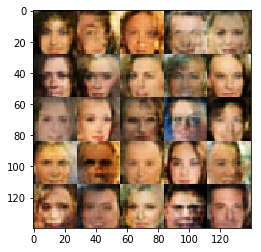

Epoch 1/1... Batch 2210... Discriminator Loss: 1.2051... Generator Loss: 1.1118
Epoch 1/1... Batch 2220... Discriminator Loss: 0.9531... Generator Loss: 1.1130
Epoch 1/1... Batch 2230... Discriminator Loss: 1.1172... Generator Loss: 1.0224
Epoch 1/1... Batch 2240... Discriminator Loss: 1.1399... Generator Loss: 0.8188
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3610... Generator Loss: 0.5833
Epoch 1/1... Batch 2260... Discriminator Loss: 0.9380... Generator Loss: 1.1087
Epoch 1/1... Batch 2270... Discriminator Loss: 1.6434... Generator Loss: 0.4064
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0397... Generator Loss: 0.9529
Epoch 1/1... Batch 2290... Discriminator Loss: 1.0328... Generator Loss: 0.9249
Epoch 1/1... Batch 2300... Discriminator Loss: 1.1060... Generator Loss: 0.8065


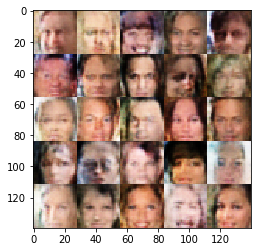

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1966... Generator Loss: 0.8498
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7986... Generator Loss: 1.3443
Epoch 1/1... Batch 2330... Discriminator Loss: 1.0329... Generator Loss: 1.1731
Epoch 1/1... Batch 2340... Discriminator Loss: 1.1494... Generator Loss: 0.8747
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1570... Generator Loss: 1.0790
Epoch 1/1... Batch 2360... Discriminator Loss: 1.3385... Generator Loss: 0.6709
Epoch 1/1... Batch 2370... Discriminator Loss: 1.0044... Generator Loss: 1.5929
Epoch 1/1... Batch 2380... Discriminator Loss: 1.1266... Generator Loss: 0.8975
Epoch 1/1... Batch 2390... Discriminator Loss: 1.3448... Generator Loss: 0.9584
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1069... Generator Loss: 0.8245


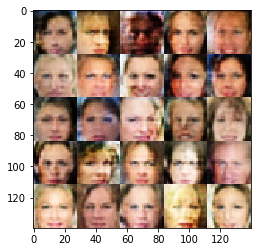

Epoch 1/1... Batch 2410... Discriminator Loss: 1.1362... Generator Loss: 0.9205
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2763... Generator Loss: 0.6348
Epoch 1/1... Batch 2430... Discriminator Loss: 1.3205... Generator Loss: 0.6854
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3083... Generator Loss: 0.7372
Epoch 1/1... Batch 2450... Discriminator Loss: 0.8926... Generator Loss: 1.1689
Epoch 1/1... Batch 2460... Discriminator Loss: 0.9723... Generator Loss: 0.9910
Epoch 1/1... Batch 2470... Discriminator Loss: 1.1250... Generator Loss: 0.9808
Epoch 1/1... Batch 2480... Discriminator Loss: 0.9817... Generator Loss: 1.1455
Epoch 1/1... Batch 2490... Discriminator Loss: 1.1184... Generator Loss: 1.0365
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2329... Generator Loss: 0.7616


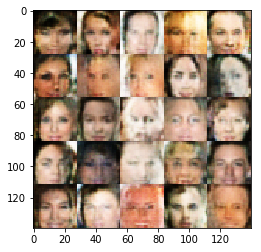

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1498... Generator Loss: 0.8285
Epoch 1/1... Batch 2520... Discriminator Loss: 1.0086... Generator Loss: 1.2310
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2078... Generator Loss: 0.7090
Epoch 1/1... Batch 2540... Discriminator Loss: 1.0710... Generator Loss: 0.9173
Epoch 1/1... Batch 2550... Discriminator Loss: 1.0492... Generator Loss: 0.8271
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2280... Generator Loss: 0.7295
Epoch 1/1... Batch 2570... Discriminator Loss: 1.0393... Generator Loss: 0.8465
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1376... Generator Loss: 0.8918
Epoch 1/1... Batch 2590... Discriminator Loss: 1.2638... Generator Loss: 0.6094
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2174... Generator Loss: 0.8613


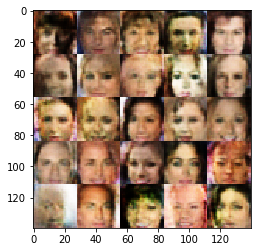

Epoch 1/1... Batch 2610... Discriminator Loss: 1.0746... Generator Loss: 0.9369
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2177... Generator Loss: 0.8674
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1687... Generator Loss: 1.0844
Epoch 1/1... Batch 2640... Discriminator Loss: 1.0886... Generator Loss: 0.8942
Epoch 1/1... Batch 2650... Discriminator Loss: 0.9704... Generator Loss: 0.9060
Epoch 1/1... Batch 2660... Discriminator Loss: 0.9710... Generator Loss: 1.0808
Epoch 1/1... Batch 2670... Discriminator Loss: 1.0800... Generator Loss: 0.9967
Epoch 1/1... Batch 2680... Discriminator Loss: 1.4506... Generator Loss: 0.7122
Epoch 1/1... Batch 2690... Discriminator Loss: 1.1229... Generator Loss: 1.2168
Epoch 1/1... Batch 2700... Discriminator Loss: 0.9406... Generator Loss: 1.2494


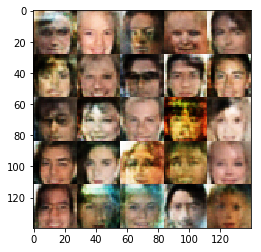

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0365... Generator Loss: 0.8318
Epoch 1/1... Batch 2720... Discriminator Loss: 1.1685... Generator Loss: 1.1325
Epoch 1/1... Batch 2730... Discriminator Loss: 0.8419... Generator Loss: 1.5963
Epoch 1/1... Batch 2740... Discriminator Loss: 0.9070... Generator Loss: 1.5702
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1500... Generator Loss: 1.2009
Epoch 1/1... Batch 2760... Discriminator Loss: 1.1642... Generator Loss: 0.8383
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2152... Generator Loss: 0.8785
Epoch 1/1... Batch 2780... Discriminator Loss: 1.1431... Generator Loss: 0.8323
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1361... Generator Loss: 0.7720
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0446... Generator Loss: 1.4749


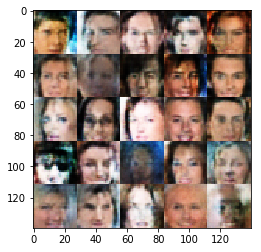

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1669... Generator Loss: 0.9232
Epoch 1/1... Batch 2820... Discriminator Loss: 1.2983... Generator Loss: 1.0507
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2373... Generator Loss: 0.7182
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2863... Generator Loss: 0.7268
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2317... Generator Loss: 0.6557
Epoch 1/1... Batch 2860... Discriminator Loss: 0.9613... Generator Loss: 1.2173
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0823... Generator Loss: 0.8771
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2024... Generator Loss: 0.7284
Epoch 1/1... Batch 2890... Discriminator Loss: 1.0945... Generator Loss: 1.2854
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3853... Generator Loss: 0.6869


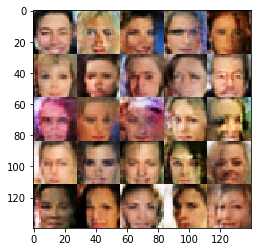

Epoch 1/1... Batch 2910... Discriminator Loss: 1.5343... Generator Loss: 0.4533
Epoch 1/1... Batch 2920... Discriminator Loss: 1.3166... Generator Loss: 1.1713
Epoch 1/1... Batch 2930... Discriminator Loss: 1.2172... Generator Loss: 0.7754
Epoch 1/1... Batch 2940... Discriminator Loss: 1.1058... Generator Loss: 0.8256
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2857... Generator Loss: 0.5846
Epoch 1/1... Batch 2960... Discriminator Loss: 0.9508... Generator Loss: 1.4618
Epoch 1/1... Batch 2970... Discriminator Loss: 0.9625... Generator Loss: 0.9826
Epoch 1/1... Batch 2980... Discriminator Loss: 0.9103... Generator Loss: 1.5229
Epoch 1/1... Batch 2990... Discriminator Loss: 1.0213... Generator Loss: 0.8865
Epoch 1/1... Batch 3000... Discriminator Loss: 1.1211... Generator Loss: 0.9253


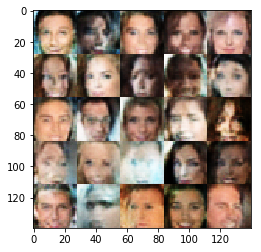

Epoch 1/1... Batch 3010... Discriminator Loss: 0.9216... Generator Loss: 1.2135
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2623... Generator Loss: 0.7062
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3446... Generator Loss: 1.0768
Epoch 1/1... Batch 3040... Discriminator Loss: 1.0783... Generator Loss: 1.1677
Epoch 1/1... Batch 3050... Discriminator Loss: 1.1250... Generator Loss: 0.8438
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1303... Generator Loss: 0.9878
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1845... Generator Loss: 1.6421
Epoch 1/1... Batch 3080... Discriminator Loss: 1.3393... Generator Loss: 0.7303
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1083... Generator Loss: 0.9326
Epoch 1/1... Batch 3100... Discriminator Loss: 1.4396... Generator Loss: 0.5169


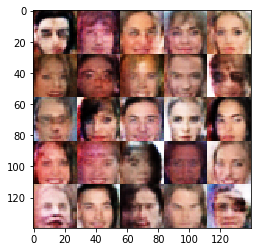

Epoch 1/1... Batch 3110... Discriminator Loss: 1.0665... Generator Loss: 0.9958
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1007... Generator Loss: 1.0193
Epoch 1/1... Batch 3130... Discriminator Loss: 0.9164... Generator Loss: 1.0326
Epoch 1/1... Batch 3140... Discriminator Loss: 0.9529... Generator Loss: 1.1300
Epoch 1/1... Batch 3150... Discriminator Loss: 0.9600... Generator Loss: 1.0360
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2295... Generator Loss: 0.6940


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.